In [1]:
%run ./libs.ipynb

pulsew = 5

%run ./ini.ipynb
%run ./signals.ipynb

AutoPhase = False

global Ss_max
global Sfilt_max
Ss_max = 2.1e-4

In [2]:
def getPlot(Ss, LOG, ENV, BASE, PulseWidth):

    #pulse signal envelope
    N = np.power(2,15) 
    env = np.square(np.abs(np.fft.fftshift(np.fft.fft(ampp_gauss,N))))
    env = env/np.max(env)
        
    #x-axis | signal envelope
    t = np.linspace(0,nptslambda,nptslambda)
    dt = t[2]-t[1];
    df = 1/(dt*N);
    fenv = np.linspace(-1*N/2,N/2-1,N)*df
    fnorm_env = fenv/(1/nptslambda/2);

    #clip relevant envelope signal
    env = env[fnorm_env <= 5] 
    fnorm_env = fnorm_env[fnorm_env <= 5]
    env = env[fnorm_env >= -5]
    fnorm_env = fnorm_env[fnorm_env >= -5]
  
    #x-axis | signal
    df_field = ofcont[2]-ofcont[1]
    dt_field = 1/(df_field*len(Ss))
    dfield = np.linspace(-len(Ss)/2,len(Ss)/2-1,len(Ss))*dt_field*3e8/2 
    fnorm_sig = dfield/(LB/2) #normalize to fo
    
    #normalize signal
    if PulseWidth >= 0.04:
        #Ss = Ss/np.max(Ss) #Ss_max 
        ind_sig = np.argmax(Ss)
        mag_sig = np.max(Ss)

        ind_env = fnorm_env[fnorm_env >= fnorm_sig[ind_sig]]
        ind_env = ind_env[0]
        ind_env = np.where(fnorm_env == ind_env)
        Dnorm = mag_sig/env[ind_env]

        Ss = Ss/Dnorm
    else:
        Ss = Ss/np.max(Ss)            

    if LOG:
        Ss = 10*np.log10(Ss)
        env = 10*np.log10(env)
   
    #plot
    fig = plt.figure(figsize = (15,4))
    ax = fig.add_subplot(111)

    if BASE:
        LBrange = fnorm_sig + 1
        LB_rect = np.heaviside(LBrange,0.5)
        LB_rect[fnorm_sig > 1] = 0
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(fnorm_sig, 0, 1, where=LB_rect > 0.5, facecolor='blue', alpha=0.15, transform=trans)

    line1 = ax.plot(fnorm_sig, Ss,'k', linewidth='1.5')
    
    if ENV:
        line2 = ax.plot(fnorm_env, env, 'tab:brown', linestyle='dotted', linewidth='2.5')
       
    plt.ylabel('Signal, a.u.', fontsize = 15)
    plt.xlabel('RF-frequency, $f/F_{oN}$', fontsize = 15)
    if LOG:
        plt.ylim([-70, 2])
    else:
        plt.ylim([0, 1.35])
    plt.xlim([-5, 5])
    plt.xticks(np.arange(-5, 5, step=1))
    plt.grid(color='k', linestyle='-', linewidth=.1)
    plt.show()    

def getPlot2(PulseWidth_text):
    x_ptrain = np.linspace(0,1,nptslambda*1-1)    
    fig = plt.figure(figsize = (2,2))
    ax = fig.add_subplot(111)
    line3 = ax.plot(x_ptrain, ptrain[1:nptslambda*1],'k')
    plt.ylim([0, 1.1])
    plt.xlim([0, 1.05])
    plt.xlabel('Time, $t/t_p$', fontsize = 15)
    plt.title('Pulse, $g(t)$')
    plt.xticks(np.arange(0, 2, step=1))
    plt.show()
    
def getSig(PulseWidth_text, f_slide, IQ_button, BG_button, LOG_button, Env_box, BASE_box):

    PulseWidth = PulseWidth_text
    if PulseWidth < 0.01:
        PulseWidth = 0.01
    ENV = Env_box
    BASE = BASE_box
    
    global pulsew
    pulsew = PulseWidth_text
    if pulsew < 0.01:
        pulsew = 0.01
    %run ./ini.ipynb
    
    global IQ
    IQ = IQ_button
    
    global BG
    BG = BG_button
     
    f = f_slide

    depth0 = f*LB/2*1e6
    
    Ss = signals(Noversampl, depth0, oof, ofcont, FILT, Order, FiltType, FILTFACT, AutoPhase, ph0, IQ, noise)
                
    getPlot(Ss, LOG_button, ENV, BASE, PulseWidth)

In [3]:
# depth
f_slide = widgets.FloatSlider(value = .5,
                              description = '$2\\tau\Delta\\nu$',
                              min = -2,
                              max = 2,
                              step = .1,
                              continuous_update = True,
                              layout=Layout(width='400px', margin='1px 0px'))

#Pulse width
PulseWidth_text = widgets.FloatText(value = 0.4,
                                    description = 'PulseWidth',
                                    min=0.04, 
                                    max=10,
                                    step = .1,
                                    layout=Layout(width='150px'))

IQ_button = widgets.ToggleButton(value = True, description = 'I/Q', layout=Layout(width='132px', margin='3px 10px'))

#BG
BG_button = widgets.ToggleButton(value = True, description = 'BG', layout=Layout(width='132px', margin='3px 1px')) 

# log
LOG_button = widgets.ToggleButton(value = True, description = 'LOG', layout=Layout(width='90px', margin='0px 1px')) 

BASE_box = widgets.Checkbox(value=True, description='Baseband', disabled=False, indent=False)

Env_box = widgets.Checkbox(value=True, description='Signal envelope, $G(f)$', disabled=False, indent=False)

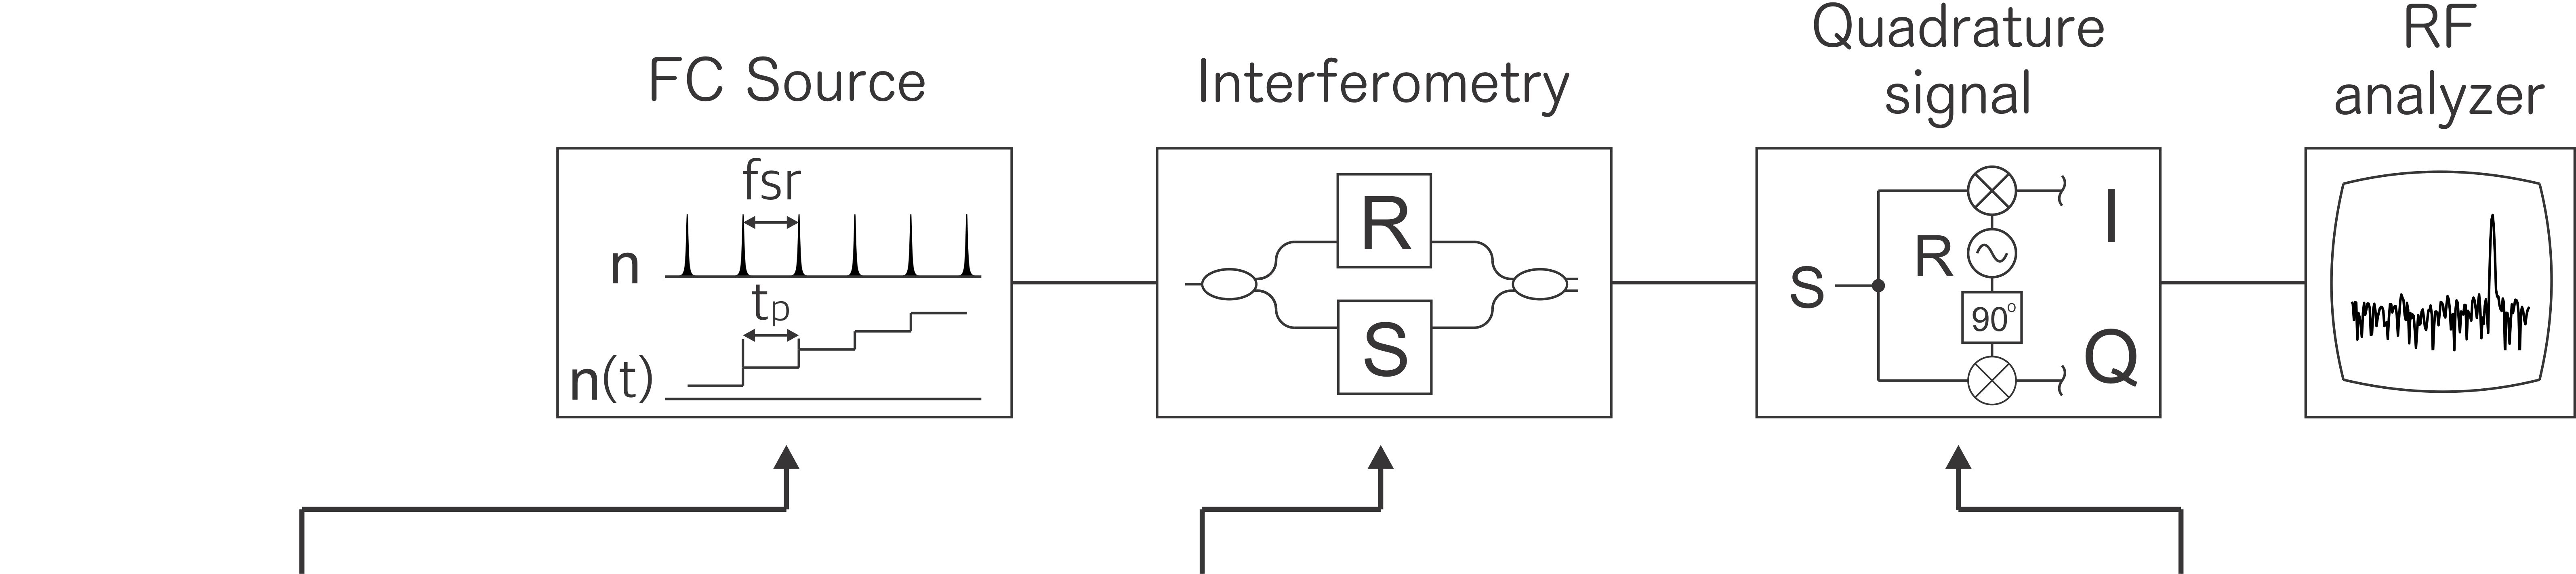

In [4]:
out = widgets.interactive_output(getSig, {'PulseWidth_text': PulseWidth_text, 'f_slide': f_slide, 'IQ_button': IQ_button, 'BG_button': BG_button, 'LOG_button': LOG_button, 
                                          'Env_box': Env_box, 'BASE_box': BASE_box})

out2 = widgets.interactive_output(getPlot2, {'PulseWidth_text': PulseWidth_text})

ui1 = widgets.VBox([PulseWidth_text], layout=widgets.Layout(display='flex', flex_flow='column', align_items='center'))
ui2 = widgets.VBox([out2, LOG_button], layout=widgets.Layout(align_items='center'))
ui3 = widgets.HBox([IQ_button], layout=widgets.Layout(display='flex', flex_flow='column', align_items='flex-end'))
ui10 = widgets.HBox([BG_button], layout=widgets.Layout(display='flex', flex_flow='column', align_items='flex-end'))

ui5 = widgets.VBox([f_slide])
ui7 = widgets.HBox([ui1, ui5, ui3, ui10], layout=widgets.Layout(align_items='flex-start'))
ui8 = widgets.HBox([ui2, out], layout=widgets.Layout(align_items='flex-start'))
ui9 = widgets.HBox([Env_box, BASE_box])

display(Image(filename='setup.png', width="1000"))
display(ui7, ui8, ui9)